In [ ]:
!nvidia-smi -L || true
!nvidia-smi || true
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

GPU 0: Tesla T4 (UUID: GPU-40575336-1e2a-f244-f744-89c97da1d9b0)
Thu Aug 14 21:03:17 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   43C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |       

In [ ]:
ARCHIVE_PATH = "/content/drive/MyDrive/archive.zip"
import os
assert os.path.exists(ARCHIVE_PATH), f"Archive not found at {ARCHIVE_PATH}"

In [ ]:
import shutil, subprocess, sys

ARCHIVE_PATH = "/content/drive/MyDrive/archive.zip"
EXTRACT_DIR = "/content/data_archive"

if os.path.exists(EXTRACT_DIR):
    shutil.rmtree(EXTRACT_DIR)
os.makedirs(EXTRACT_DIR, exist_ok=True)
result = subprocess.run(
    ["unzip", "-q", "-o", ARCHIVE_PATH, "-d", EXTRACT_DIR],
    stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True
)

if result.returncode != 0:
    print("Unzip stderr:\n", result.stderr)
    raise RuntimeError("Extraction failed. Check that the ZIP is valid.")

file_count = 0
for root, _, files in os.walk(EXTRACT_DIR):
    file_count += len(files)

print(f" Extraction complete to: {EXTRACT_DIR}")
print(f"Total files found: {file_count}")

 Extraction complete to: /content/data_archive
Total files found: 136002


In [ ]:
BASE_DIR = "/content/data_archive"
for root, dirs, files in os.walk(BASE_DIR):
    indent = "  " * (root[len(BASE_DIR):].count(os.sep))
    folder = os.path.basename(root) if os.path.basename(root) else "(root)"
    print(f"{indent}{folder}/")
    for f in files[:10]:
        print(f"{indent}  {f}")
    if len(files) > 10:
        print(f"{indent}  ... and {len(files)-10} more files")

data_archive/
  bdd100k_seg/
    bdd100k/
      seg/
        color_labels/
          val/
            a91b7555-00000535_train_color.png
            98c81ae2-c861eb14_train_color.png
            a0ea324c-9e5a6a24_train_color.png
            a91b7555-00000270_train_color.png
            8ab55ec6-b34eeff9_train_color.png
            7e365190-9193658c_train_color.png
            a91b7555-00000520_train_color.png
            a4761d4d-d8a1dbfb_train_color.png
            a70faa46-6630da64_train_color.png
            94be8008-00000000_train_color.png
            ... and 990 more files
          train/
            6a00c92c-09d0090e_train_color.png
            71ae6276-81724033_train_color.png
            5eda07c0-d3c25831_train_color.png
            5b8651a2-bfa5be55_train_color.png
            4a45ec3b-5272157a_train_color.png
            1537b75f-db29e390_train_color.png
            c69e5864-010993d7_train_color.png
            78c1b906-2c59e821_train_color.png
            52ba66d6-4aafde44_

In [ ]:
from PIL import Image, ImageStat
from pathlib import Path

SRC_BASE = "/content/data_archive/bdd100k/bdd100k/images/10k"
OUT_BASE = "/content/cyclegan_10k"
for p in [f"{OUT_BASE}/trainA", f"{OUT_BASE}/trainB", f"{OUT_BASE}/valA", f"{OUT_BASE}/valB"]:
    Path(p).mkdir(parents=True, exist_ok=True)

def list_images(folder):
    exts = ('.jpg','.jpeg','.png','.bmp','.webp')
    return [str(Path(folder)/f) for f in os.listdir(folder) if f.lower().endswith(exts)]

train_imgs = list_images(f"{SRC_BASE}/train")
val_imgs   = list_images(f"{SRC_BASE}/val")

def luminance_mean(p):
    try:
        im = Image.open(p).convert('L')
        return ImageStat.Stat(im).mean[0]
    except:
        return None

def split_day_night(paths):
    vals = [(p, luminance_mean(p)) for p in paths]
    vals = [(p,m) for p,m in vals if m is not None]
    if not vals:
        return [], []
    meds = sorted(m for _,m in vals)
    thr = meds[len(meds)//2]
    day = [p for p,m in vals if m >= thr]
    night = [p for p,m in vals if m <  thr]
    return day, night

train_day, train_night = split_day_night(train_imgs)
val_day,   val_night   = split_day_night(val_imgs)

def link_many(paths, dst_dir):
    for p in paths:
        dst = Path(dst_dir)/Path(p).name
        try:
            os.symlink(p, dst)
        except FileExistsError:
            pass
        except OSError:
            if not dst.exists():
                import shutil
                shutil.copy2(p, dst)

link_many(train_day,   f"{OUT_BASE}/trainA")
link_many(train_night, f"{OUT_BASE}/trainB")
link_many(val_day,     f"{OUT_BASE}/valA")
link_many(val_night,   f"{OUT_BASE}/valB")

print("trainA:", len(os.listdir(f"{OUT_BASE}/trainA")))
print("trainB:", len(os.listdir(f"{OUT_BASE}/trainB")))
print("valA:",   len(os.listdir(f"{OUT_BASE}/valA")))
print("valB:",   len(os.listdir(f"{OUT_BASE}/valB")))


trainA: 3500
trainB: 3500
valA: 500
valB: 500


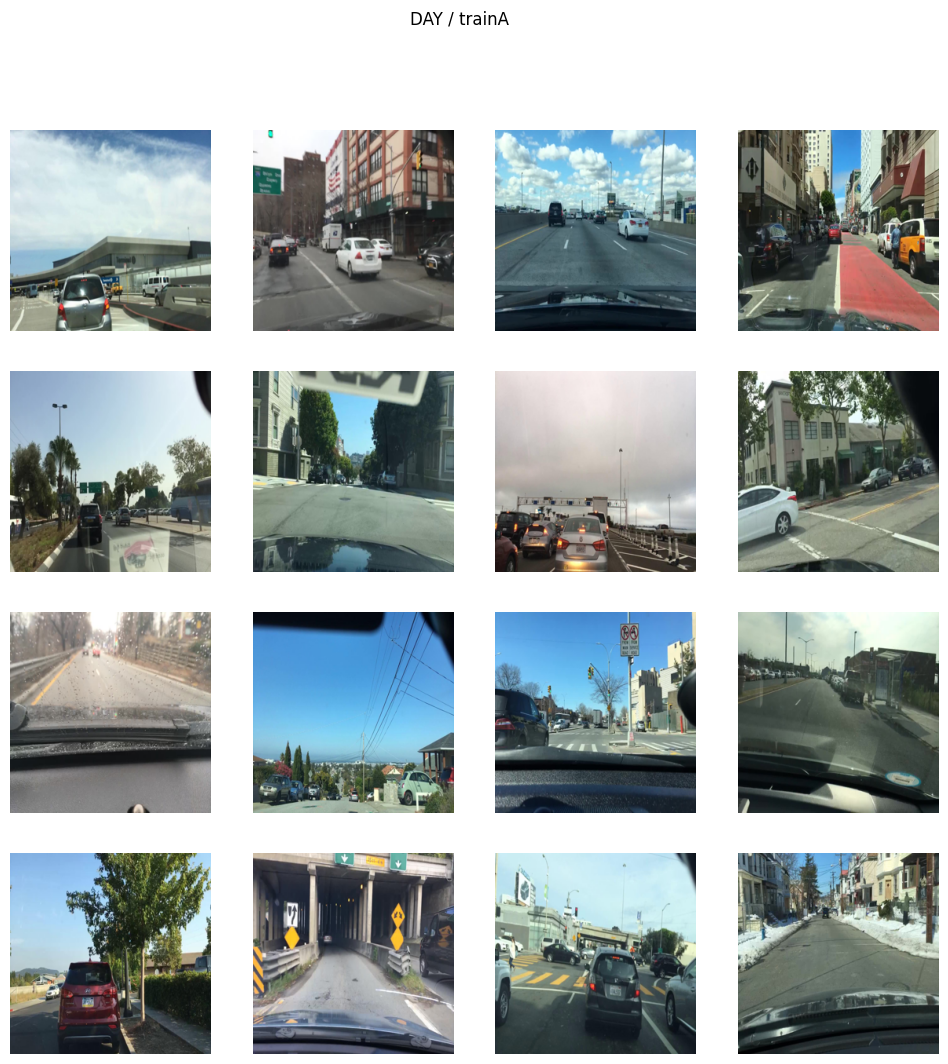

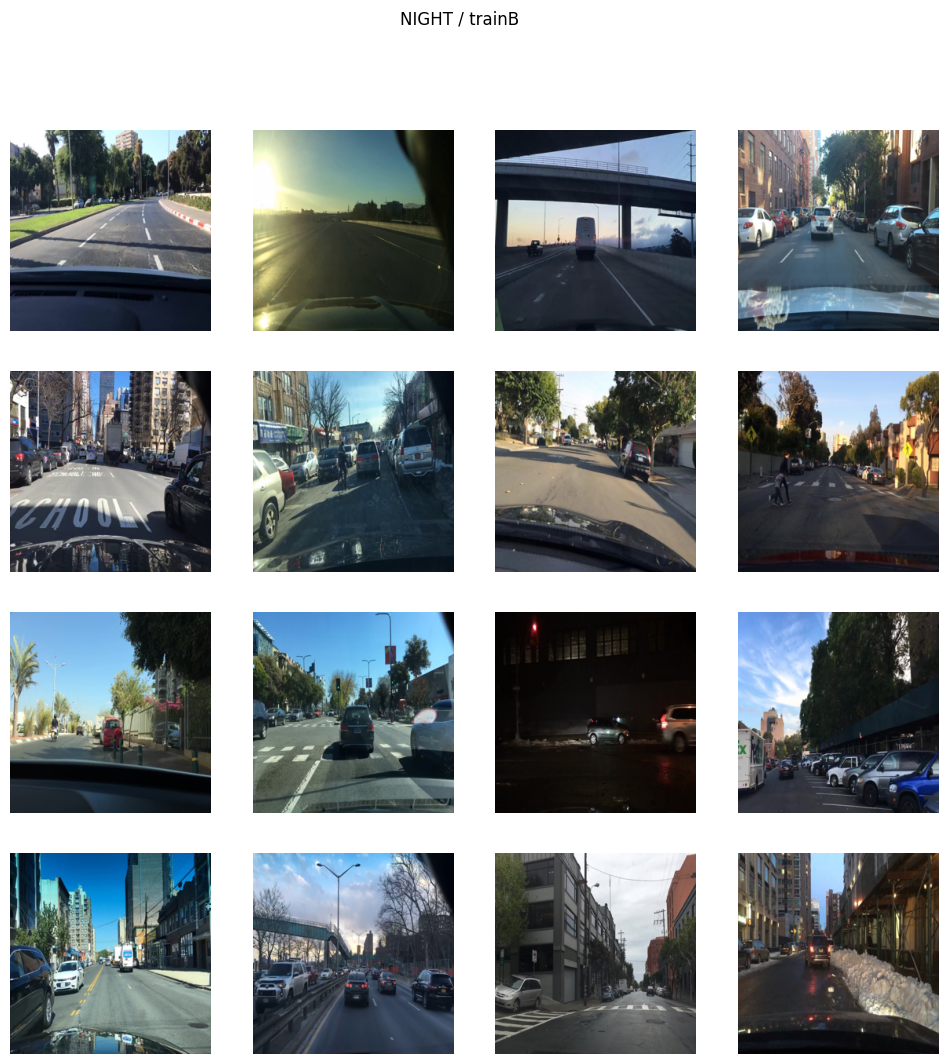

In [ ]:
import random, numpy as np, matplotlib.pyplot as plt
BASE = "/content/cyclegan_10k"
def sample_paths(folder, n=16):
    ps = [os.path.join(folder,f) for f in os.listdir(folder)]
    return random.sample(ps, min(n, len(ps)))

def show_grid(paths, title):
    cols, size = 4, 256
    rows = int(np.ceil(len(paths)/cols))
    plt.figure(figsize=(cols*3, rows*3))
    for i,p in enumerate(paths):
        plt.subplot(rows, cols, i+1)
        im = Image.open(p).convert('RGB').resize((size,size))
        plt.imshow(im); plt.axis('off')
    plt.suptitle(title); plt.show()

show_grid(sample_paths(f"{BASE}/trainA"), "DAY / trainA")
show_grid(sample_paths(f"{BASE}/trainB"), "NIGHT / trainB")


In [ ]:
import random, itertools, time
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, utils
from torchvision.datasets import ImageFolder
from torch.utils.data import Dataset, DataLoader
from tqdm.auto import tqdm
DATA_ROOT = "/content/cyclegan_10k"
SAVE_ROOT = "/content/cyclegan_runs/10k_baseline"
os.makedirs(SAVE_ROOT, exist_ok=True)
os.makedirs(f"{SAVE_ROOT}/samples", exist_ok=True)
os.makedirs(f"{SAVE_ROOT}/checkpoints", exist_ok=True)

def list_images_dir(d):
    exts = ('.jpg','.jpeg','.png','.bmp','.webp')
    return [os.path.join(d,f) for f in os.listdir(d) if f.lower().endswith(exts)]

class SimpleImageDataset(Dataset):
    def __init__(self, root, transform):
        self.paths = list_images_dir(root)
        self.transform = transform
    def __len__(self):
        return len(self.paths)
    def __getitem__(self, idx):
        x = Image.open(self.paths[idx]).convert('RGB')
        if self.transform: x = self.transform(x)
        return x, 0

class UnalignedPairs(Dataset):
    def __init__(self, dirA, dirB, transform):
        self.A = SimpleImageDataset(dirA, transform)
        self.B = SimpleImageDataset(dirB, transform)
        self.lenA, self.lenB = len(self.A), len(self.B)
        self.length = max(self.lenA, self.lenB)
    def __len__(self):
        return self.length
    def __getitem__(self, idx):
        a,_ = self.A[idx % self.lenA]
        b,_ = self.B[random.randint(0, self.lenB-1)]
        return a, b

class ResnetBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, 1, 0),
            nn.InstanceNorm2d(dim, affine=False),
            nn.ReLU(True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(dim, dim, 3, 1, 0),
            nn.InstanceNorm2d(dim, affine=False)
        )
    def forward(self, x):
        return x + self.block(x)

class ResnetGenerator(nn.Module):
    def __init__(self, in_c=3, out_c=3, ngf=64, n_blocks=9):
        super().__init__()
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(in_c, ngf, 7, 1, 0),
            nn.InstanceNorm2d(ngf, affine=False),
            nn.ReLU(True),
            nn.Conv2d(ngf, ngf*2, 3, 2, 1),
            nn.InstanceNorm2d(ngf*2, affine=False),
            nn.ReLU(True),
            nn.Conv2d(ngf*2, ngf*4, 3, 2, 1),
            nn.InstanceNorm2d(ngf*4, affine=False),
            nn.ReLU(True),
        ]
        for _ in range(n_blocks):
            model += [ResnetBlock(ngf*4)]
        model += [
            nn.ConvTranspose2d(ngf*4, ngf*2, 3, 2, 1, output_padding=1),
            nn.InstanceNorm2d(ngf*2, affine=False),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 3, 2, 1, output_padding=1),
            nn.InstanceNorm2d(ngf, affine=False),
            nn.ReLU(True),
            nn.ReflectionPad2d(3),
            nn.Conv2d(ngf, out_c, 7, 1, 0),
            nn.Tanh()
        ]
        self.model = nn.Sequential(*model)
    def forward(self, x):
        return self.model(x)

class PatchDiscriminator(nn.Module):
    def __init__(self, in_c=3, ndf=64):
        super().__init__()
        def C(i,o,n=True):
            layers = [nn.Conv2d(i,o,4,2,1)]
            if n: layers += [nn.InstanceNorm2d(o, affine=False)]
            layers += [nn.LeakyReLU(0.2, True)]
            return layers
        layers = []
        layers += C(in_c, ndf, n=False)
        layers += C(ndf, ndf*2)
        layers += C(ndf*2, ndf*4)
        layers += [nn.Conv2d(ndf*4, 1, 4, 1, 1)]
        self.model = nn.Sequential(*layers)
    def forward(self, x):
        return self.model(x)

def init_weights(m):
    if isinstance(m, (nn.Conv2d, nn.ConvTranspose2d)):
        nn.init.normal_(m.weight, 0.0, 0.02)
        if m.bias is not None: nn.init.constant_(m.bias, 0)

class ImagePool:
    def __init__(self, size=50):
        self.size = size
        self.data = []
    def query(self, imgs):
        res = []
        for img in imgs.detach():
            img = img.unsqueeze(0)
            if len(self.data) < self.size:
                self.data.append(img)
                res.append(img)
            else:
                if random.random() > 0.5:
                    idx = random.randrange(self.size)
                    tmp = self.data[idx].clone()
                    self.data[idx] = img
                    res.append(tmp)
                else:
                    res.append(img)
        return torch.cat(res, dim=0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
size = 256
transform_train = transforms.Compose([
    transforms.Resize(int(size*1.12), Image.BICUBIC),
    transforms.RandomCrop(size),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])
transform_val = transforms.Compose([
    transforms.Resize((size, size), Image.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
])

train_set = UnalignedPairs(f"{DATA_ROOT}/trainA", f"{DATA_ROOT}/trainB", transform_train)
valA = SimpleImageDataset(f"{DATA_ROOT}/valA", transform_val)
valB = SimpleImageDataset(f"{DATA_ROOT}/valB", transform_val)
batch_size = 2
num_workers = 2
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

G_AB = ResnetGenerator().to(device)
G_BA = ResnetGenerator().to(device)
D_A = PatchDiscriminator().to(device)
D_B = PatchDiscriminator().to(device)
G_AB.apply(init_weights); G_BA.apply(init_weights); D_A.apply(init_weights); D_B.apply(init_weights)

criterion_GAN = nn.MSELoss()
criterion_cycle = nn.L1Loss()
criterion_id = nn.L1Loss()
lambda_cyc = 10.0
lambda_id = 5.0

opt_G = optim.Adam(itertools.chain(G_AB.parameters(), G_BA.parameters()), lr=2e-4, betas=(0.5, 0.999))
opt_D_A = optim.Adam(D_A.parameters(), lr=2e-4, betas=(0.5, 0.999))
opt_D_B = optim.Adam(D_B.parameters(), lr=2e-4, betas=(0.5, 0.999))
lr_scheduler_G = optim.lr_scheduler.LinearLR(opt_G, start_factor=1.0, end_factor=0.0, total_iters=5)
lr_scheduler_D_A = optim.lr_scheduler.LinearLR(opt_D_A, start_factor=1.0, end_factor=0.0, total_iters=5)
lr_scheduler_D_B = optim.lr_scheduler.LinearLR(opt_D_B, start_factor=1.0, end_factor=0.0, total_iters=5)

pool_A = ImagePool(50)
pool_B = ImagePool(50)

def denorm(x):
    return (x * 0.5 + 0.5).clamp(0,1)

def eval_and_save(epoch, step):
    G_AB.eval(); G_BA.eval()
    with torch.no_grad():
        def sample_grid(ds, toB=True, tag="A2B"):
            if len(ds) == 0: return
            idxs = random.sample(range(len(ds)), min(4, len(ds)))
            ims = []
            for idx in idxs:
                x,_ = ds[idx]
                x = x.unsqueeze(0).to(device)
                if toB:
                    y = G_AB(x); x_rec = G_BA(y)
                else:
                    y = G_BA(x); x_rec = G_AB(y)
                ims += [denorm(x.cpu()), denorm(y.cpu()), denorm(x_rec.cpu())]
            grid = utils.make_grid(torch.cat(ims, dim=0), nrow=3)
            utils.save_image(grid, f"{SAVE_ROOT}/samples/ep{epoch:02d}_it{step:06d}_{tag}.png")
        sample_grid(valA, toB=True, tag="A2B")
        sample_grid(valB, toB=False, tag="B2A")
    G_AB.train(); G_BA.train()

epochs = 5
global_step = 0
for epoch in range(1, epochs+1):
    pbar = tqdm(train_loader, desc=f"Epoch {epoch}/{epochs}", leave=False)
    for a_real, b_real in pbar:
        a_real = a_real.to(device)
        b_real = b_real.to(device)

        opt_G.zero_grad()
        b_fake = G_AB(a_real)
        a_rec = G_BA(b_fake)
        a_fake = G_BA(b_real)
        b_rec = G_AB(a_fake)

        out_B_fake = D_B(b_fake)
        out_A_fake = D_A(a_fake)
        valid_B = torch.ones_like(out_B_fake, device=device)
        valid_A = torch.ones_like(out_A_fake, device=device)

        loss_GAN_AB = criterion_GAN(out_B_fake, valid_B)
        loss_GAN_BA = criterion_GAN(out_A_fake, valid_A)
        loss_cycle = criterion_cycle(a_rec, a_real) * lambda_cyc + criterion_cycle(b_rec, b_real) * lambda_cyc
        loss_id = criterion_id(G_AB(b_real), b_real) * lambda_id + criterion_id(G_BA(a_real), a_real) * lambda_id
        loss_G = loss_GAN_AB + loss_GAN_BA + loss_cycle + loss_id
        loss_G.backward()
        opt_G.step()

        opt_D_A.zero_grad()
        out_A_real = D_A(a_real)
        fake_A_pool = pool_A.query(a_fake.detach())
        out_A_pool = D_A(fake_A_pool)
        loss_D_A_real = criterion_GAN(out_A_real, torch.ones_like(out_A_real, device=device))
        loss_D_A_fake = criterion_GAN(out_A_pool, torch.zeros_like(out_A_pool, device=device))
        loss_D_A = 0.5 * (loss_D_A_real + loss_D_A_fake)
        loss_D_A.backward()
        opt_D_A.step()

        opt_D_B.zero_grad()
        out_B_real = D_B(b_real)
        fake_B_pool = pool_B.query(b_fake.detach())
        out_B_pool = D_B(fake_B_pool)
        loss_D_B_real = criterion_GAN(out_B_real, torch.ones_like(out_B_real, device=device))
        loss_D_B_fake = criterion_GAN(out_B_pool, torch.zeros_like(out_B_pool, device=device))
        loss_D_B = 0.5 * (loss_D_B_real + loss_D_B_fake)
        loss_D_B.backward()
        opt_D_B.step()

        global_step += 1
        pbar.set_postfix(G=float(loss_G.item()), D_A=float(loss_D_A.item()), D_B=float(loss_D_B.item()))
        if global_step % 500 == 0:
            eval_and_save(epoch, global_step)

    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()
    torch.save(G_AB.state_dict(), f"{SAVE_ROOT}/checkpoints/G_AB_ep{epoch}.pt")
    torch.save(G_BA.state_dict(), f"{SAVE_ROOT}/checkpoints/G_BA_ep{epoch}.pt")
    torch.save(D_A.state_dict(), f"{SAVE_ROOT}/checkpoints/D_A_ep{epoch}.pt")
    torch.save(D_B.state_dict(), f"{SAVE_ROOT}/checkpoints/D_B_ep{epoch}.pt")
    eval_and_save(epoch, global_step)

Epoch 1/5:   0%|          | 0/1750 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1750 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1750 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1750 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1750 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e3f98490cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e3f98490cc0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7e3f98490cc0>

In [ ]:
import glob, math, random, numpy as np, pandas as pd, torch
from skimage.metrics import structural_similarity as ssim, peak_signal_noise_ratio as psnr

os.makedirs(f"{SAVE_ROOT}/eval", exist_ok=True)
G_AB.eval(); G_BA.eval()

try:
    import lpips
except:
    import sys, subprocess
    subprocess.run([sys.executable, "-m", "pip", "install", "-q", "lpips"], check=True)
    import lpips

lpips_net = lpips.LPIPS(net='alex').to(device)

def to_np01(t):
    t = denorm(t).cpu().squeeze(0)
    return t.permute(1,2,0).numpy()

def eval_domain(ds, toB=True, tag="A2B", limit=500):
    n = min(len(ds), limit)
    idxs = random.sample(range(len(ds)), n)
    rows = []
    triples = []
    with torch.no_grad():
        for idx in tqdm(idxs, desc=f"Eval {tag}", leave=False):
            x,_ = ds[idx]
            x = x.unsqueeze(0).to(device)
            if toB:
                y = G_AB(x); x_rec = G_BA(y)
            else:
                y = G_BA(x); x_rec = G_AB(y)
            x_np = to_np01(x)
            xr_np = to_np01(x_rec)
            s = ssim(x_np, xr_np, data_range=1.0, channel_axis=2)
            p = psnr(x_np, xr_np, data_range=1.0)
            l = lpips_net(x, x_rec).mean().item()
            rows.append((idx, s, p, l))
            triples += [denorm(x.cpu()), denorm(y.cpu()), denorm(x_rec.cpu())]
    df = pd.DataFrame(rows, columns=["index","ssim_cycle","psnr_cycle","lpips_cycle"])
    utils.save_image(torch.cat(triples[:48], dim=0), f"{SAVE_ROOT}/eval/grid_{tag}.png", nrow=3)
    df.to_csv(f"{SAVE_ROOT}/eval/metrics_{tag}.csv", index=False)
    print(tag, "mean SSIM:", float(df['ssim_cycle'].mean()), "mean PSNR:", float(df['psnr_cycle'].mean()), "mean LPIPS:", float(df['lpips_cycle'].mean()))
    return df

df_A2B = eval_domain(valA, toB=True, tag="A2B", limit=500)
df_B2A = eval_domain(valB, toB=False, tag="B2A", limit=500)


Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:05<00:00, 42.8MB/s]


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Eval A2B:   0%|          | 0/500 [00:00<?, ?it/s]

A2B mean SSIM: 0.8302597403526306 mean PSNR: 24.91420787391997 mean LPIPS: 0.20969092550873755


Eval B2A:   0%|          | 0/500 [00:00<?, ?it/s]

B2A mean SSIM: 0.8302717208862305 mean PSNR: 25.227516040770816 mean LPIPS: 0.19925431309640407


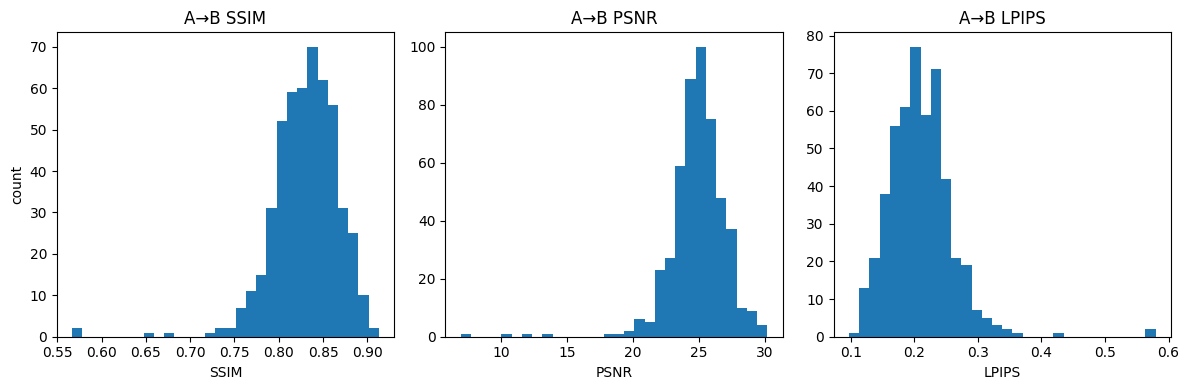

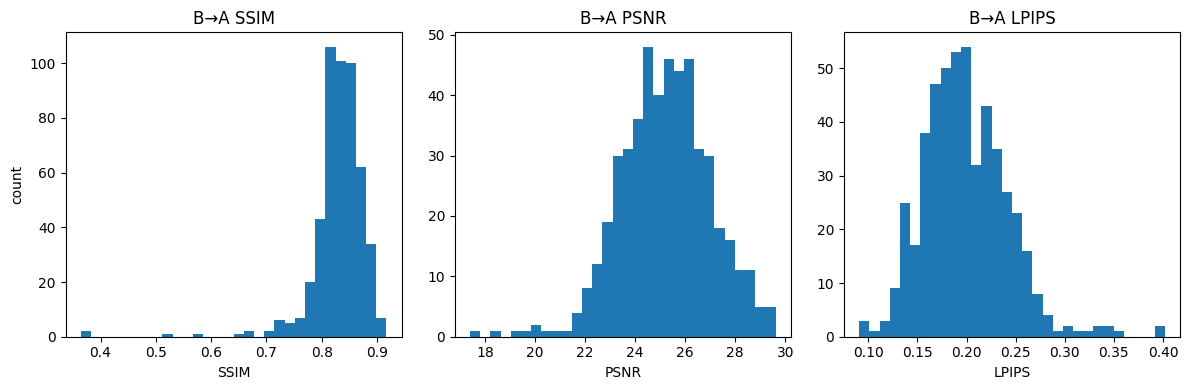

In [ ]:
G_AB.eval(); G_BA.eval()

if 'df_A2B' not in globals():
    df_A2B = pd.read_csv(f"{SAVE_ROOT}/eval/metrics_A2B.csv")
if 'df_B2A' not in globals():
    df_B2A = pd.read_csv(f"{SAVE_ROOT}/eval/metrics_B2A.csv")

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.hist(df_A2B['ssim_cycle'], bins=30); plt.xlabel('SSIM'); plt.ylabel('count'); plt.title('A→B SSIM')
plt.subplot(1,3,2); plt.hist(df_A2B['psnr_cycle'], bins=30); plt.xlabel('PSNR'); plt.title('A→B PSNR')
plt.subplot(1,3,3); plt.hist(df_A2B['lpips_cycle'], bins=30); plt.xlabel('LPIPS'); plt.title('A→B LPIPS')
plt.tight_layout(); plt.show()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.hist(df_B2A['ssim_cycle'], bins=30); plt.xlabel('SSIM'); plt.ylabel('count'); plt.title('B→A SSIM')
plt.subplot(1,3,2); plt.hist(df_B2A['psnr_cycle'], bins=30); plt.xlabel('PSNR'); plt.title('B→A PSNR')
plt.subplot(1,3,3); plt.hist(df_B2A['lpips_cycle'], bins=30); plt.xlabel('LPIPS'); plt.title('B→A LPIPS')
plt.tight_layout(); plt.show()

Epoch eval:   0%|          | 0/5 [00:00<?, ?it/s]

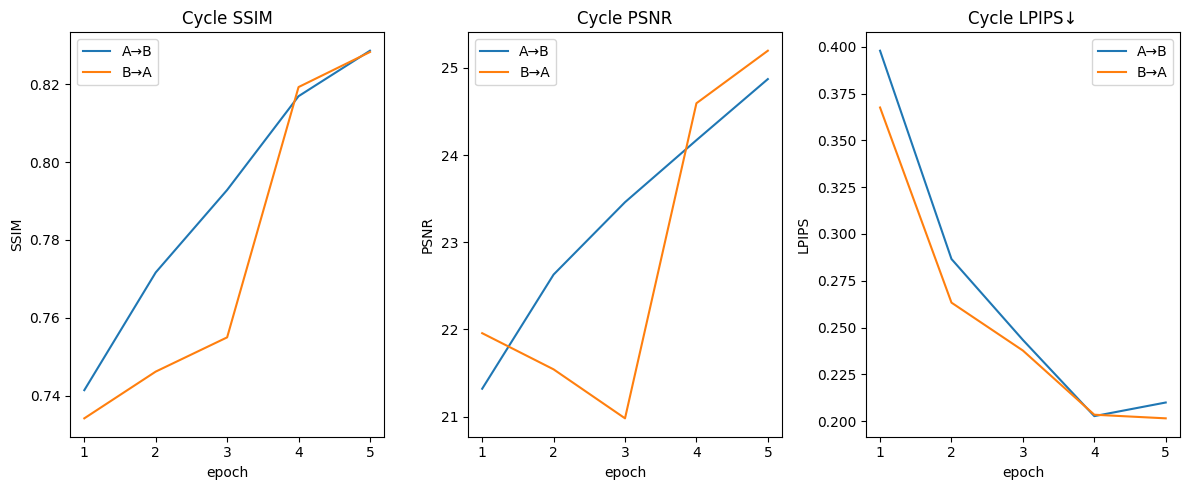

In [ ]:
import glob, numpy as np, pandas as pd, matplotlib.pyplot as plt, torch

ckpt_ab = sorted(glob.glob(f"{SAVE_ROOT}/checkpoints/G_AB_ep*.pt"))
ckpt_ba = sorted(glob.glob(f"{SAVE_ROOT}/checkpoints/G_BA_ep*.pt"))
def parse_ep(p): return int(os.path.splitext(os.path.basename(p))[0].split("_ep")[-1])
ep_list = sorted(list(set(parse_ep(p) for p in ckpt_ab) & set(parse_ep(p) for p in ckpt_ba)))

rng = np.random.RandomState(42)
nA = min(len(valA), 200)
nB = min(len(valB), 200)
idxsA = rng.choice(len(valA), size=nA, replace=False).tolist()
idxsB = rng.choice(len(valB), size=nB, replace=False).tolist()

def eval_epoch(ep):
    G_AB.load_state_dict(torch.load(f"{SAVE_ROOT}/checkpoints/G_AB_ep{ep}.pt", map_location=device))
    G_BA.load_state_dict(torch.load(f"{SAVE_ROOT}/checkpoints/G_BA_ep{ep}.pt", map_location=device))
    G_AB.eval(); G_BA.eval()
    ssim_A, psnr_A, lpips_A = [], [], []
    ssim_B, psnr_B, lpips_B = [], [], []
    with torch.no_grad():
        for idx in idxsA:
            x,_ = valA[idx]
            x = x.unsqueeze(0).to(device)
            y = G_AB(x); xr = G_BA(y)
            x_np = to_np01(x)
            xr_np = to_np01(xr)
            ssim_A.append(ssim(x_np, xr_np, data_range=1.0, channel_axis=2))
            psnr_A.append(psnr(x_np, xr_np, data_range=1.0))
            lpips_A.append(lpips_net(x, xr).mean().item())
        for idx in idxsB:
            x,_ = valB[idx]
            x = x.unsqueeze(0).to(device)
            y = G_BA(x); xr = G_AB(y)
            x_np = to_np01(x)
            xr_np = to_np01(xr)
            ssim_B.append(ssim(x_np, xr_np, data_range=1.0, channel_axis=2))
            psnr_B.append(psnr(x_np, xr_np, data_range=1.0))
            lpips_B.append(lpips_net(x, xr).mean().item())
    return {
        "epoch": ep,
        "ssim_A2B": float(np.mean(ssim_A)),
        "psnr_A2B": float(np.mean(psnr_A)),
        "lpips_A2B": float(np.mean(lpips_A)),
        "ssim_B2A": float(np.mean(ssim_B)),
        "psnr_B2A": float(np.mean(psnr_B)),
        "lpips_B2A": float(np.mean(lpips_B)),
    }

rows = []
for ep in tqdm(ep_list, desc="Epoch eval"):
    rows.append(eval_epoch(ep))
df_ep = pd.DataFrame(rows).sort_values("epoch").reset_index(drop=True)
df_ep.to_csv(f"{SAVE_ROOT}/eval/epoch_metrics.csv", index=False)

plt.figure(figsize=(12,5))
plt.subplot(1,3,1); plt.plot(df_ep["epoch"], df_ep["ssim_A2B"], label="A→B"); plt.plot(df_ep["epoch"], df_ep["ssim_B2A"], label="B→A"); plt.xlabel("epoch"); plt.ylabel("SSIM"); plt.title("Cycle SSIM"); plt.legend()
plt.subplot(1,3,2); plt.plot(df_ep["epoch"], df_ep["psnr_A2B"], label="A→B"); plt.plot(df_ep["epoch"], df_ep["psnr_B2A"], label="B→A"); plt.xlabel("epoch"); plt.ylabel("PSNR"); plt.title("Cycle PSNR"); plt.legend()
plt.subplot(1,3,3); plt.plot(df_ep["epoch"], df_ep["lpips_A2B"], label="A→B"); plt.plot(df_ep["epoch"], df_ep["lpips_B2A"], label="B→A"); plt.xlabel("epoch"); plt.ylabel("LPIPS"); plt.title("Cycle LPIPS↓"); plt.legend()
plt.tight_layout(); plt.show()


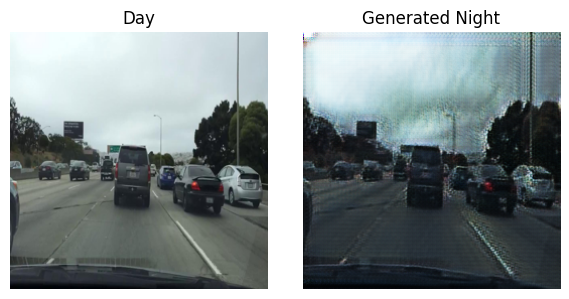

Saved to /content/cyclegan_runs/10k_baseline/example_day2night.png


In [ ]:
idx = random.randrange(len(valA))
G_AB.eval()
with torch.no_grad():
    x,_ = valA[idx]
    x = x.unsqueeze(0).to(device)
    y = G_AB(x)
x_np = denorm(x.squeeze(0)).permute(1,2,0).cpu().numpy()
y_np = denorm(y.squeeze(0)).permute(1,2,0).cpu().numpy()
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(x_np); plt.axis('off'); plt.title('Day')
plt.subplot(1,2,2); plt.imshow(y_np); plt.axis('off'); plt.title('Generated Night')
plt.tight_layout(); plt.show()
utils.save_image(torch.cat([denorm(x.cpu()), denorm(y.cpu())], dim=0), f"{SAVE_ROOT}/example_day2night.png", nrow=2)
print(f"Saved to {SAVE_ROOT}/example_day2night.png")

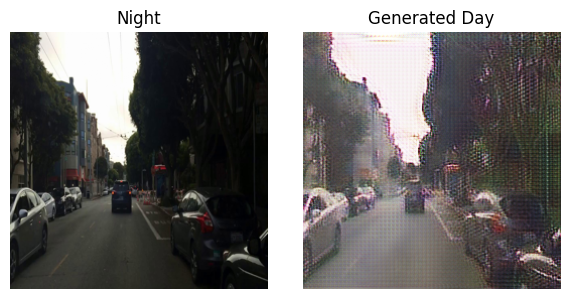

Saved to /content/cyclegan_runs/10k_baseline/example_night2day.png


In [ ]:
idx = random.randrange(len(valB))
G_BA.eval()
with torch.no_grad():
    x,_ = valB[idx]
    x = x.unsqueeze(0).to(device)
    y = G_BA(x)
x_np = denorm(x.squeeze(0)).permute(1,2,0).cpu().numpy()
y_np = denorm(y.squeeze(0)).permute(1,2,0).cpu().numpy()
plt.figure(figsize=(6,3))
plt.subplot(1,2,1); plt.imshow(x_np); plt.axis('off'); plt.title('Night')
plt.subplot(1,2,2); plt.imshow(y_np); plt.axis('off'); plt.title('Generated Day')
plt.tight_layout(); plt.show()
utils.save_image(torch.cat([denorm(x.cpu()), denorm(y.cpu())], dim=0), f"{SAVE_ROOT}/example_night2day.png", nrow=2)
print(f"Saved to {SAVE_ROOT}/example_night2day.png")


In [ ]:
WEIGHT_DIR = f"{SAVE_ROOT}/export"
os.makedirs(WEIGHT_DIR, exist_ok=True)

torch.save(G_AB.state_dict(), f"{WEIGHT_DIR}/G_AB_weights.pth")
torch.save(G_BA.state_dict(), f"{WEIGHT_DIR}/G_BA_weights.pth")
torch.save(D_A.state_dict(), f"{WEIGHT_DIR}/D_A_weights.pth")
torch.save(D_B.state_dict(), f"{WEIGHT_DIR}/D_B_weights.pth")

torch.save({
    "epoch": globals().get("epoch", None),
    "G_AB": G_AB.state_dict(),
    "G_BA": G_BA.state_dict(),
    "D_A": D_A.state_dict(),
    "D_B": D_B.state_dict(),
    "opt_G": opt_G.state_dict(),
    "opt_D_A": opt_D_A.state_dict(),
    "opt_D_B": opt_D_B.state_dict(),
}, f"{WEIGHT_DIR}/checkpoint_full.pt")

G_AB.eval(); G_BA.eval()
dummy = torch.randn(1,3,256,256, device=device)
G_AB_ts = torch.jit.trace(G_AB, dummy)
G_BA_ts = torch.jit.trace(G_BA, dummy)
G_AB_ts.save(f"{WEIGHT_DIR}/G_AB_torchscript.pt")
G_BA_ts.save(f"{WEIGHT_DIR}/G_BA_torchscript.pt")

DRIVE_OUT = "/content/drive/MyDrive/cyclegan_weights_10k"
os.makedirs(DRIVE_OUT, exist_ok=True)
for fname in ["G_AB_weights.pth","G_BA_weights.pth","D_A_weights.pth","D_B_weights.pth","checkpoint_full.pt","G_AB_torchscript.pt","G_BA_torchscript.pt"]:
    src = f"{WEIGHT_DIR}/{fname}"
    dst = f"{DRIVE_OUT}/{fname}"
    if os.path.exists(src):
        shutil.copy2(src, dst)

print("Saved to:", WEIGHT_DIR)
print("Copied to Drive:", DRIVE_OUT)

Saved to: /content/cyclegan_runs/10k_baseline/export
Copied to Drive: /content/drive/MyDrive/cyclegan_weights_10k
